In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("columbine/imdb-dataset-sentiment-analysis-in-csv-format")

print("Path to dataset files:", path)

Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format/versions/1


In [18]:
import pandas as pd
df_train = pd.read_csv('Train.csv')  # or however you load
df_val = pd.read_csv('Valid.csv')
le = LabelEncoder()
df_train["label_id"] = le.fit_transform(df_train["label"])  # e.g. cat=0, dog=1, car=2, etc.
df_val["label_id"] = le.fit_transform(df_val["label"]) 
num_classes = len(le.classes_)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
import numpy as np

In [6]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=32):
        self.texts = df["text"].tolist()
        self.labels = df["label_id"].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        # encoding["input_ids"]: shape [1, max_len]
        # We want them as 1D tensors, so we do .squeeze(0)
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": label
        }

In [7]:
def supervised_contrastive_loss(embeddings, labels, temperature=0.07):
    """
    embeddings: Tensor [batch_size, embed_dim]
    labels:     Tensor [batch_size]
    """
    # Normalize for cosine similarity
    emb = nn.functional.normalize(embeddings, p=2, dim=1)  # [B, D]
    batch_size = emb.size(0)

    # Compute cosine similarity between all pairs => [B, B]
    sim_matrix = torch.matmul(emb, emb.t())  # shape [B, B]
    sim_matrix = sim_matrix / temperature

    # Mask out self-comparisons on diagonal
    logits_mask = torch.ones_like(sim_matrix) - torch.eye(batch_size, device=sim_matrix.device)
    sim_matrix = sim_matrix * logits_mask

    # Build positives mask (same label => 1, else 0), then remove self
    labels = labels.unsqueeze(1)  # [B,1]
    match_mask = (labels == labels.t()).float()  # [B,B]
    positives_mask = match_mask * logits_mask

    # Exponentiate similarity
    exp_sim = torch.exp(sim_matrix)
    # Numerator = sum of exp(sim) over positives
    numerator = torch.sum(exp_sim * positives_mask, dim=1)
    # Denominator = sum of exp(sim) over entire row
    denominator = torch.sum(exp_sim, dim=1)

    loss = -torch.log(numerator / (denominator + 1e-12) + 1e-12)
    return loss.mean()


In [8]:
class BertForContrastive(nn.Module):
    def __init__(self, pretrained_name="bert-base-uncased", dropout_p=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_name)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input_ids, attention_mask):
        # AutoModel returns last_hidden_state, pooler_output, etc.
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # last_hidden_state => [batch_size, seq_len, hidden_dim]
        last_hidden = outputs.last_hidden_state
        # We'll do average pooling
        pooled = last_hidden.mean(dim=1)  # [batch_size, hidden_dim]
        embeddings = self.dropout(pooled)
        return embeddings


In [19]:
def train_contrastive_pytorch(
    df_train,
    df_val,
    tokenizer,
    model,
    device="cuda",
    epochs=5,
    batch_size=8,
    patience=2,
    lr=2e-5
):
    """
    Trains `model` (instance of BertForContrastive or similar) on df_train with
    supervised contrastive loss, using df_val for early stopping.

    Args:
      df_train: DataFrame with columns ["text", "label_id"] for training.
      df_val:   DataFrame with columns ["text", "label_id"] for validation.
      tokenizer: a Hugging Face tokenizer (e.g. AutoTokenizer.from_pretrained(...))
      model:   an instance of BertForContrastive (nn.Module)
      device:  "cuda" or "cpu"
      epochs:  max number of epochs
      batch_size: how many samples per batch
      patience: how many epochs of no improvement before stopping
      lr:      learning rate

    Returns:
      The best-scoring (lowest val loss) model (already loaded with best weights).
    """
    # Build Dataset / DataLoader for train & val
    train_dataset = TextDataset(df_train, tokenizer, max_len=128)
    val_dataset   = TextDataset(df_val,   tokenizer, max_len=128)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    # We'll save the best model’s state here
    best_model_path = "best_model.pth"

    for epoch in range(1, epochs+1):
        ###################################################################
        # 1) Training loop
        ###################################################################
        model.train()
        total_train_loss = 0.0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            embeddings = model(input_ids, attention_mask=attention_mask)
            loss = supervised_contrastive_loss(embeddings, labels, temperature=0.07)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        ###################################################################
        # 2) Validation loop
        ###################################################################
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                val_embeddings = model(input_ids, attention_mask=attention_mask)
                val_loss = supervised_contrastive_loss(val_embeddings, labels)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch [{epoch}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}")

        ###################################################################
        # 3) Early stopping check
        ###################################################################
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the best model so far
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    ###################################################################
    # 4) Load the best model before returning
    ###################################################################
    print(f"Loading best model from val loss = {best_val_loss:.4f}")
    model.load_state_dict(torch.load(best_model_path))
    return model

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = BertForContrastive("distilbert-base-uncased").to(device)

model = train_contrastive_pytorch(
    df_train=df_train,
    df_val=df_val,
    tokenizer=tokenizer,
    model=model,
    device=device,
    epochs=10,
    batch_size=32,
    patience=3
    lr=1e-5
)


Using device: cuda
Epoch [1/10] | Train Loss: 0.3510 | Val Loss: 0.3344
Epoch [2/10] | Train Loss: 0.2403 | Val Loss: 0.3203
Epoch [3/10] | Train Loss: 0.1490 | Val Loss: 0.3483
Epoch [4/10] | Train Loss: 0.0797 | Val Loss: 0.3582
Epoch [5/10] | Train Loss: 0.0439 | Val Loss: 0.3799
Early stopping triggered.
Loading best model from val loss = 0.3203


In [21]:
# Saving
torch.save(model.state_dict(), "distilbert_trained.pth") 

In [35]:
def load_model_for_inference(model_class, checkpoint_path, device="cuda"):
    """
    model_class: the class you used for training (e.g., BertForContrastive).
    checkpoint_path: path to your saved model weights (e.g. "best_model.pth").
    device: "cuda" if GPU is available, otherwise "cpu".
    """
    model = model_class()
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()  # set to inference mode (disables dropout, etc.)
    return model

def get_embeddings(texts, model, tokenizer, device="cuda", max_length=32):
    """
    Produce embeddings for one or multiple texts using either a fine-tuned
    or the original DistilBERT model.

    Args:
      texts: a single string or a list of strings
      model: a trained nn.Module in eval mode
             - Could be your custom DistilBertForContrastive (returns Tensor)
             - Or the original DistilBERT (returns BaseModelOutput)
      tokenizer: the same tokenizer used in training
      device: "cuda" or "cpu"
      max_length: max tokens per text

    Returns:
      A NumPy array of shape [batch_size, embedding_dim] with the embeddings.
    """
    if isinstance(texts, str):
        texts = [texts]  # convert single string to list

    # Tokenize the input
    encodings = tokenizer(
        texts,
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # If outputs is already a tensor (e.g. from your fine-tuned contrastive model),
        # we can use it directly.
        if isinstance(outputs, torch.Tensor):
            embeddings = outputs
        else:
            # Otherwise, if it's a BaseModelOutput (like from the original DistilBERT),
            # we manually pool the last_hidden_state.
            # DistilBERT: outputs.last_hidden_state => [batch_size, seq_len, hidden_dim]
            hidden_states = outputs.last_hidden_state
            # A simple mean pooling across seq_len dimension:
            embeddings = hidden_states.mean(dim=1)

        embeddings_np = embeddings.cpu().numpy()

    return embeddings_np


In [24]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# 3) Load the model
#    Make sure you import/define the BertForContrastive class somewhere
#    from my_code import BertForContrastive
model = load_model_for_inference(
    model_class=lambda: BertForContrastive(pretrained_name="distilbert-base-uncased"),
    checkpoint_path="distilbert_trained.pth",
    device=device
)

In [25]:
texts_to_encode = [
    "The cat sat on the mat",
    "Dogs are great pets",
    "Cars drive on roads"
]
embeddings = get_embeddings(texts_to_encode, model, tokenizer, device=device, max_length=128)

# Testing the embeddings

In [42]:
df_test = pd.read_csv("Test.csv")
df_test = df_test.sample(500)
labels = df_test['label'].to_numpy()
review = df_test['text'].to_list()

In [43]:
model_original = AutoModel.from_pretrained("distilbert-base-uncased")
model_original.to("cuda")
model_original.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [44]:
embedding_1 = get_embeddings(review, model, tokenizer, device=device, max_length=128)
embedding_2 = get_embeddings(review, model_original, tokenizer, device=device, max_length=128)

In [45]:
embedding_1.shape

(500, 768)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


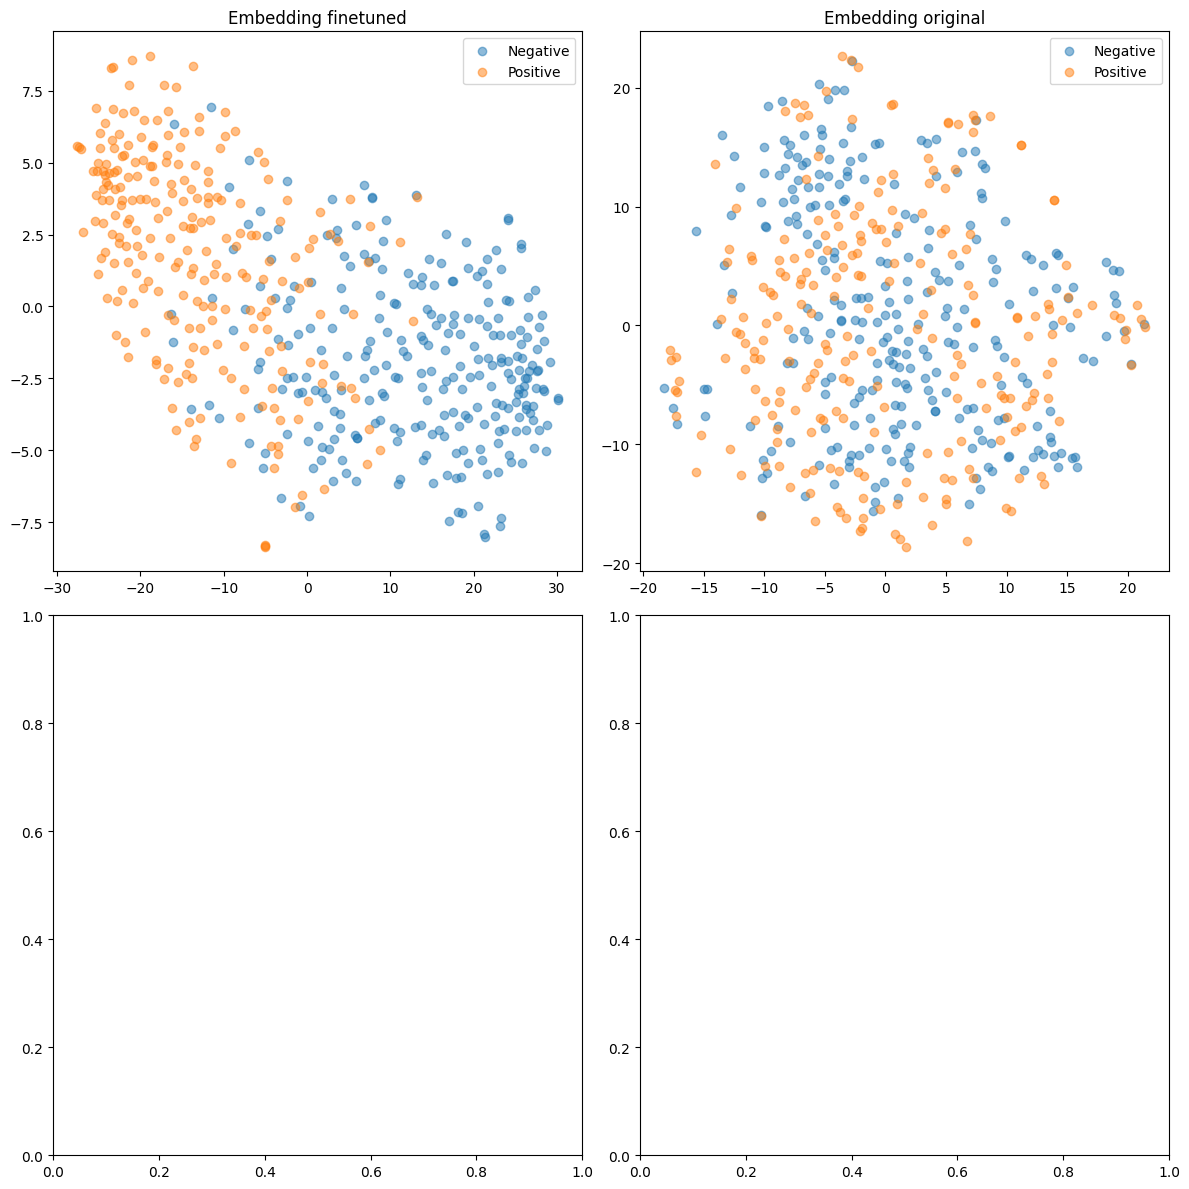

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

names=['finetuned', 'original']
# Function to perform t-SNE and plot
def tsne_plot(embeddings, labels):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    for i, embedding in enumerate(embeddings):
        # Perform t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(embedding)

        # Plot
        ax = axs[i//2, i%2]
        ax.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1], label='Negative', alpha=0.5)
        ax.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1], label='Positive', alpha=0.5)
        ax.set_title(f'Embedding {names[i]}')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Perform t-SNE and plot for all embeddings
tsne_plot([embedding_1, embedding_2], labels)